# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [1]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [2]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [3]:
# Import the necessary CSVs to Pandas DataFrames
file_path = Path("sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path = Path("neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [4]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    
    sfo_housing_units = sfo_data["housing_units"].groupby(sfo_data.index).mean()
    
    fig_housing_units = plt.figure()
    plot_housing_units = sfo_housing_units.plot.bar()
    plot_housing_units.set_xlabel("Year", fontsize=12)
    plot_housing_units.set_ylabel("Housing Units", fontsize=12)
    plot_housing_units.set_title(
        "Housing Units in San Francisco from 2010 to 2016", fontsize=14, fontweight="bold"
    )
    # Optional Challenge: Use the min, max, and std to scale the y limits of the chart
    sfo_housing_avg = sfo_data["housing_units"].groupby(sfo_data.index).mean()
    housing_units_std = sfo_housing_avg.std()
    housing_units_min = min(sfo_housing_avg)
    housing_units_max = max(sfo_housing_avg)

    plot_housing_units.set_ylim(
        housing_units_min - housing_units_std, housing_units_max + housing_units_std
    )
    plt.close(fig_housing_units)
    return pn.pane.Matplotlib(fig_housing_units, tight=True)
    


def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    
    df_avg_costs = (
        sfo_data[["sale_price_sqr_foot", "gross_rent"]]
        .groupby(sfo_data.index)
        .mean()
    )
    
    fig_avg_gross_rent = plt.figure()
    plot_avg_gross_rent = df_avg_costs["gross_rent"].plot(color="red")
    plot_avg_gross_rent.set_xlabel("Year", fontsize=12)
    plot_avg_gross_rent.set_ylabel("Gross Rent", fontsize=12)
    plot_avg_gross_rent.set_title(
        "Average Gross Rent in San Francisco", fontsize=14, fontweight="bold"
    )
    plt.close(fig_avg_gross_rent)
    return pn.pane.Matplotlib(fig_avg_gross_rent, tight=True)



def average_sales_price():
    """Average Sales Price Per Year."""
    
    sfo_avg_costs = (
        sfo_data[["sale_price_sqr_foot", "gross_rent"]]
        .groupby(sfo_data.index)
        .mean()
    )
    fig_avg_sale_price = plt.figure()
    plot_avg_sale_price = sfo_avg_costs['sale_price_sqr_foot'].plot(color='purple')
    plot_avg_sale_price.set_xlabel('Year', fontsize=12)
    plot_avg_sale_price.set_ylabel('Price per SqFt', fontsize=12)
    plot_avg_sale_price.set_title('Average Gross Rent by Year', fontsize=14, fontweight="bold"
    )
    plt.close(fig_avg_sale_price)
    return pn.pane.Matplotlib(fig_avg_sale_price, tight=True)



def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    
    sfo_costs = sfo_data.groupby([sfo_data.index, "neighborhood"]).mean()
    sfo_costs.reset_index(inplace=True)
    sfo_costs.rename(columns={"level_0": "year"}, inplace=True)
    
    sale_price_curve = sfo_costs.hvplot.line(
        "year",
        "sale_price_sqr_foot",
        xlabel="Year",
        ylabel="Avg. Sale Price per Square Foot",
        groupby="neighborhood",
    )
    return sale_price_curve
    
    


def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""

    sfo_expensive_neighborhoods = sfo_data.groupby(by="neighborhood").mean()
    sfo_expensive_neighborhoods = sfo_expensive_neighborhoods.sort_values(
        by="sale_price_sqr_foot", ascending=False
    ).head(10)
    sfo_expensive_neighborhoods = sfo_expensive_neighborhoods.reset_index()
    
    sfo_expensive_neighborhoods.hvplot.bar(
        "neighborhood",
        "sale_price_sqr_foot",
        title="Top 10 Expensive Neighborhoods in SFO",
        xlabel="Neighborhood",
        ylabel="Avg. Sale Price per Square Foot",
        height=400,
        rot=90
    )
    


def most_expensive_neighborhoods_rent_sales():
    """Comparison of Rent and Sales Prices of Most Expensive Neighborhoods."""   
    file_path = Path("neighborhoods_coordinates.csv")
    sfo_neighborhood_locations = pd.read_csv(file_path)
    sfo_all_neighborhoods = sfo_data.groupby(by="neighborhood").mean()
    sfo_all_neighborhoods.reset_index(inplace=True)
    sfo_all_neighborhoods.rename(columns={"neighborhood": "Neighborhood"}, inplace=True)
    sfo_all_neighborhoods = pd.merge(
        sfo_neighborhood_locations, sfo_all_neighborhoods, on="Neighborhood", how="inner"
    )
    
    px.set_mapbox_access_token(map_box_api)
    neighborhood_map = px.scatter_mapbox(
        sfo_all_neighborhoods,
        lat="Lat",
        lon="Lon",
        size="sale_price_sqr_foot",
        color="gross_rent",
        color_continuous_scale=px.colors.cyclical.IceFire,
        size_max=15,
        zoom=11,
        width=1000,
        hover_name="Neighborhood",
        title="Average Sale Price Per Square Foot and Gross Rent in San Francisco",
    )
    
    
def parallel_coordinates():
    """Parallel Coordinates Plot."""
    sfo_costs = sfo_data.groupby([sfo_data.index, "neighborhood"]).mean()
    sfo_costs.reset_index(inplace=True)
    sfo_costs.rename(columns={"level_0": "year"}, inplace=True)
    
    sfo_expensive_neighborhoods = sfo_data.groupby(by="neighborhood").mean()
    sfo_expensive_neighborhoods = sfo_expensive_neighborhoods.sort_values(
        by="sale_price_sqr_foot", ascending=False
    ).head(10)
    sfo_expensive_neighborhoods = sfo_expensive_neighborhoods.reset_index()
    
    px.parallel_coordinates(
        sfo_expensive_neighborhoods,
        color="sale_price_sqr_foot",
        color_continuous_scale=px.colors.sequential.Inferno,
        title="Parallel Coordinates Analysis of Most Expensive San Francisco Neighborhoods"
)
    

    


def parallel_categories():
    """Parallel Categories Plot."""
    sfo_costs = sfo_data.groupby([sfo_data.index, "neighborhood"]).mean()
    sfo_costs.reset_index(inplace=True)
    sfo_costs.rename(columns={"level_0": "year"}, inplace=True)
    
    sfo_expensive_neighborhoods = sfo_data.groupby(by="neighborhood").mean()
    sfo_expensive_neighborhoods = sfo_expensive_neighborhoods.sort_values(
        by="sale_price_sqr_foot", ascending=False).head(10)
    sfo_expensive_neighborhoods = sfo_expensive_neighborhoods.reset_index()
    px.parallel_categories(
    sfo_expensive_neighborhoods,
    color="sale_price_sqr_foot",
    color_continuous_scale=px.colors.sequential.Inferno,
    title="Parallel Categories Analysis of Most Expensive San Francisco Neighborhoods"
    )


def neighborhood_map():
    """Neighborhood Map."""
    file_path = Path("neighborhoods_coordinates.csv")
    sfo_neighborhood_locations = pd.read_csv(file_path)
    sfo_all_neighborhoods = sfo_data.groupby(by="neighborhood").mean()
    sfo_all_neighborhoods.reset_index(inplace=True)
    sfo_all_neighborhoods.rename(columns={"neighborhood": "Neighborhood"}, inplace=True)
    sfo_all_neighborhoods = pd.merge(
        sfo_neighborhood_locations, sfo_all_neighborhoods, on="Neighborhood", how="inner"
    )
    px.set_mapbox_access_token(map_box_api)
    neighborhood_map = px.scatter_mapbox(
        sfo_all_neighborhoods,
        lat="Lat",
        lon="Lon",
        size="sale_price_sqr_foot",
        color="gross_rent",
        color_continuous_scale=px.colors.cyclical.IceFire,
        size_max=15,
        zoom=11,
        width=1000,
        hover_name="Neighborhood",
        title="Average Sale Price Per Square Foot and Gross Rent in San Francisco",
    )
    


def sunburst():
    """Sunburst Plot."""
    
    fig = px.sunburst(
        sfo_expensive_neighborhoods_per_year,
        path=["year", "neighborhood"],
        values='sale_price_sqr_foot',
        color='gross_rent',
        color_continuous_scale='Blues',
        height=700
    )
    



## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [5]:
# Create a Title for the Dashboard
sfo_real_estate_dashboard = "SFO Neighborhood Statistics"


# Create a tab layout for the dashboard
tabs = pn.Tabs(
    ("SFO Market Analysis", pn.Column(housing_units_per_year(), average_gross_rent(), average_sales_price())),
    ("SFO Neighborhood Analysis", pn.Column(average_price_by_neighborhood(), top_most_expensive_neighborhoods(), most_expensive_neighborhoods_rent_sales())),
    ("Parallel Plot Analysis", pn.Column(parallel_coordinates(), parallel_categories(), width=960)),
)

# Create the dashboard
sfo_dashboard = pn.Column(pn.Row(sfo_real_estate_dashboard), tabs, width=900)
    

## Serve the Panel Dashboard

Column(width=900)
    [0] Row
        [0] Markdown(str)
    [1] Tabs
        [0] Column
            [0] Matplotlib(Figure, tight=True)
            [1] Matplotlib(Figure, tight=True)
            [2] Matplotlib(Figure, tight=True)
        [1] Column
            [0] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                    [1] VSpacer()
            [1] Str(None)
            [2] Str(None)
        [2] Column(width=960)
            [0] Str(None)
            [1] Str(None)
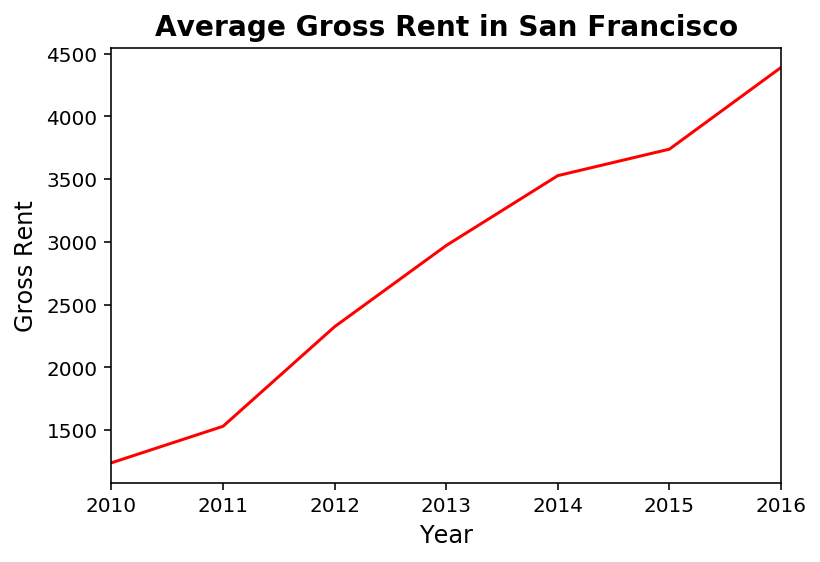
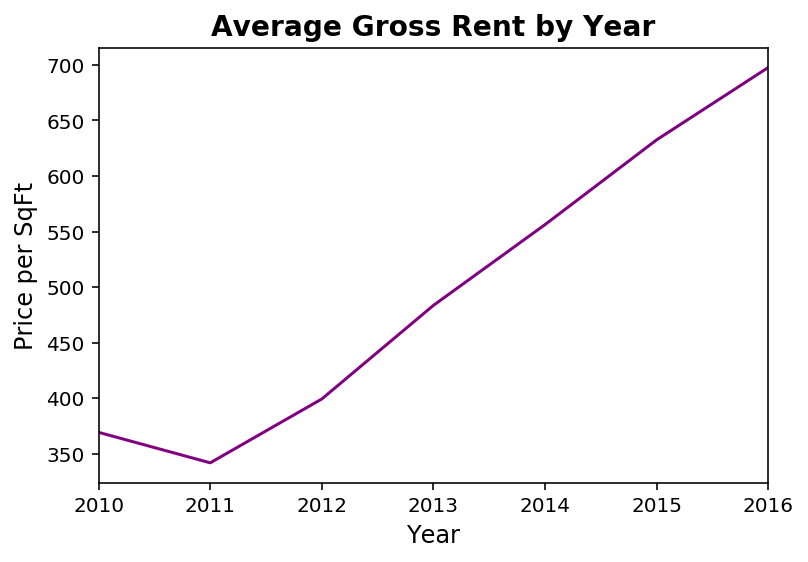
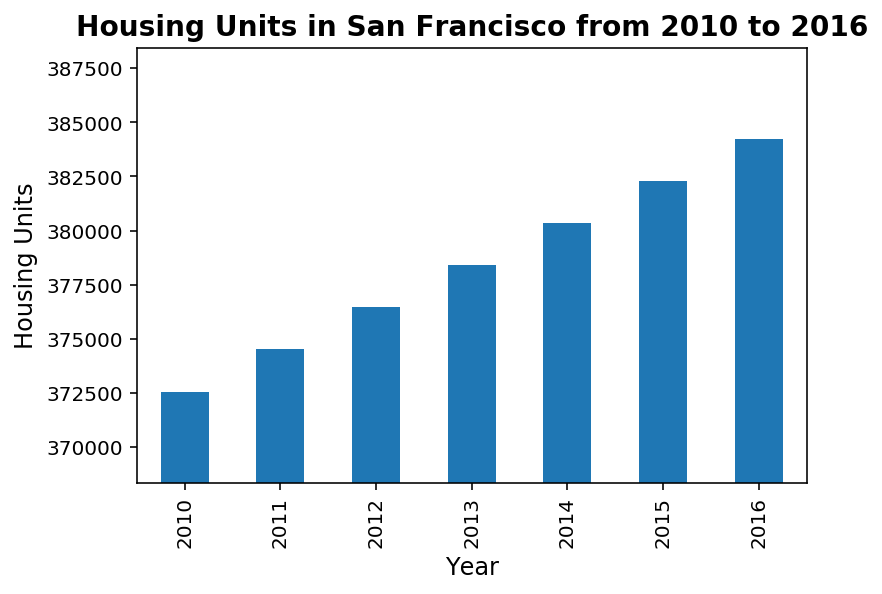

In [6]:
# Serve the# dashboard
sfo_dashboard.servable()

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

Text(0.5, 1.0, 'Housing Units in San Francisco from 2010 to 2016')

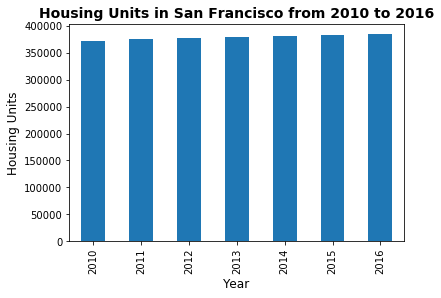

In [7]:
# housing_units_per_year()
sfo_housing_avg = sfo_data["housing_units"].groupby(sfo_data.index).mean()
fig_housing_units = plt.figure()
plot_housing_units = sfo_housing_avg.plot.bar()
plot_housing_units.set_xlabel("Year", fontsize=12)
plot_housing_units.set_ylabel("Housing Units", fontsize=12)
plot_housing_units.set_title(
    "Housing Units in San Francisco from 2010 to 2016", fontsize=14, fontweight="bold"
)

In [8]:
# average_gross_rent()
sfo_costs = sfo_data.groupby([sfo_data.index, "neighborhood"]).mean()
sfo_costs.reset_index(inplace=True)
sfo_costs.rename(columns={"level_0": "year"}, inplace=True)
sfo_costs.hvplot.line(
    "year",
    "gross_rent",
    xlabel="Year",
    ylabel="Gross Rent",
    groupby="neighborhood",
)

:DynamicMap   [neighborhood]
   :Curve   [year]   (gross_rent)

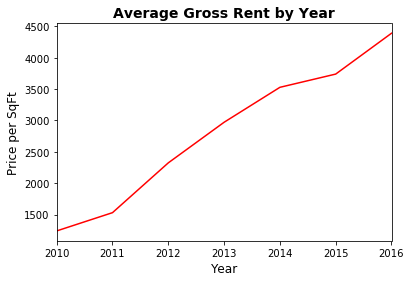

In [9]:
# average_sales_price()
sfo_avg_costs = (
    sfo_data[["sale_price_sqr_foot", "gross_rent"]]
    .groupby(sfo_data.index)
    .mean()
)

fig = plt.figure()
bar_chart = sfo_avg_costs['gross_rent'].plot(color='red')
bar_chart.set_xlabel('Year', fontsize=12)
bar_chart.set_ylabel('Price per SqFt', fontsize=12)
bar_chart.set_title('Average Gross Rent by Year', fontsize=14, fontweight="bold")
plt.show()
plt.close(fig)

In [10]:
# average_price_by_neighborhood()
sfo_costs = sfo_data.groupby([sfo_data.index, "neighborhood"]).mean()
sfo_costs.reset_index(inplace=True)
sfo_costs.rename(columns={"level_0": "year"}, inplace=True)
sfo_costs.hvplot.line(
    "year",
    "sale_price_sqr_foot",
    xlabel="Year",
    ylabel="Avg. Sale Price per Square Foot",
    groupby="neighborhood",
)

:DynamicMap   [neighborhood]
   :Curve   [year]   (sale_price_sqr_foot)

In [11]:
# top_most_expensive_neighborhoods()
sfo_expensive_neighborhoods = sfo_data.groupby(by="neighborhood").mean()
sfo_expensive_neighborhoods = sfo_expensive_neighborhoods.sort_values(
    by="sale_price_sqr_foot", ascending=False
).head(10)
sfo_expensive_neighborhoods = sfo_expensive_neighborhoods.reset_index()
sfo_expensive_neighborhoods.hvplot.bar(
    "neighborhood",
    "sale_price_sqr_foot",
    title="Top 10 Expensive Neighborhoods in SFO",
    xlabel="Neighborhood",
    ylabel="Avg. Sale Price per Square Foot",
    height=400,
    rot=90
)

:Bars   [neighborhood]   (sale_price_sqr_foot)

In [12]:
# most_expensive_neighborhoods_rent_sales()
sfo_costs.hvplot.bar(
    "year",
    ["gross_rent", "sale_price_sqr_foot"],
    title="Top 10 Expensive Neighborhoods in SFO",
    xlabel="Neighborhood",
    ylabel="Num Housing Units",
    groupby='neighborhood',
    height=500,
    rot=90
)

:DynamicMap   [neighborhood]
   :Bars   [year,Variable]   (value)

In [13]:
# neighborhood_map().show()
file_path = Path("neighborhoods_coordinates.csv")
sfo_neighborhood_locations = pd.read_csv(file_path)
sfo_all_neighborhoods = sfo_data.groupby(by="neighborhood").mean()
sfo_all_neighborhoods.reset_index(inplace=True)
sfo_all_neighborhoods.rename(columns={"neighborhood": "Neighborhood"}, inplace=True)

sfo_all_neighborhoods = pd.merge(
    sfo_neighborhood_locations, sfo_all_neighborhoods, on="Neighborhood", how="inner"
)
px.set_mapbox_access_token(map_box_api)
neighborhood_map = px.scatter_mapbox(
    sfo_all_neighborhoods,
    lat="Lat",
    lon="Lon",
    size="sale_price_sqr_foot",
    color="gross_rent",
    color_continuous_scale=px.colors.cyclical.IceFire,
    size_max=15,
    zoom=11,
    width=1000,
    hover_name="Neighborhood",
    title="Average Sale Price Per Square Foot and Gross Rent in San Francisco",
)
neighborhood_map.show()

In [14]:
# parallel_categories()
px.parallel_categories(
    sfo_expensive_neighborhoods,
    color="sale_price_sqr_foot",
    color_continuous_scale=px.colors.sequential.Inferno,
    title="Parallel Categories Analysis of Most Expensive San Francisco Neighborhoods"
)

In [15]:
# parallel_coordinates()
px.parallel_coordinates(
    sfo_expensive_neighborhoods,
    color="sale_price_sqr_foot",
    color_continuous_scale=px.colors.sequential.Inferno,
    title="Parallel Coordinates Analysis of Most Expensive San Francisco Neighborhoods"
)

In [16]:
# sunburst()
sfo_expensive_neighborhoods_per_year = sfo_costs[sfo_costs["neighborhood"].isin(sfo_expensive_neighborhoods["neighborhood"])]
fig = px.sunburst(
    sfo_expensive_neighborhoods_per_year,
    path=["year", "neighborhood"],
    values='sale_price_sqr_foot',
    color='gross_rent',
    color_continuous_scale='Blues',
    height=700
)

fig.show()